Проверим, что мы работаем на GPU:

In [ ]:
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



Импортируем библиотеки.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications import ResNet152V2 
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

#print(os.listdir("/content/drive/MyDrive/Ford_vs_Ferrari"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

Python       : 3.7.12 (default, Sep 10 2021, 00:21:48) 
Numpy        : 1.19.5
Tensorflow   : 2.6.0
Keras        : 2.6.0


Поменял размер изображений при подаче в сеть на 71 и bachsize на 128 для скорости, чтобы можно было провести больше экспериментов.

---



In [ ]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.
# Изображения подаваемые в сеть уменьшил до 128 чтобы сократить время обучения
EPOCHS               = 5  # эпох на обучение
BATCH_SIZE           = 128 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 71 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '/content/drive/MyDrive/Ford_vs_Ferrari/'
PATH = "../working/car/" # рабочая директория

RANDOM_SEED =42

Для начала ознакомимся с нашими данными, для этого подключимся к гугл диску, куда скачаны файлы

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")

In [ ]:
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [ ]:
train_df.Category.value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

Распределение классов достаточно равномерное - это хорошо.

In [ ]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile("/content/drive/MyDrive/Ford_vs_Ferrari/"+data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['train', 'test_upload']


Пример картинок (random sample)


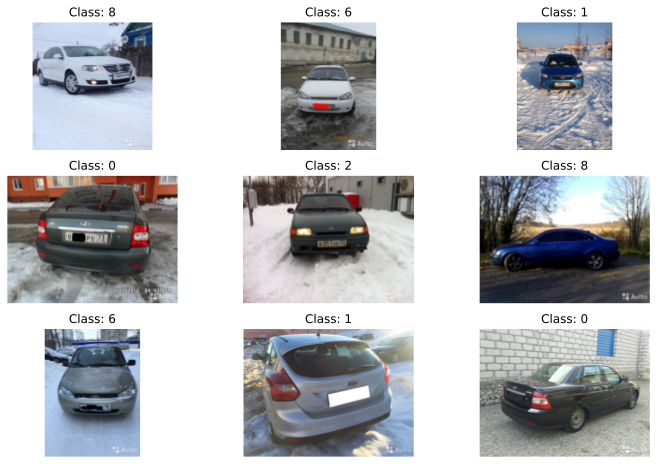

In [ ]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

# Подготовка данных

Подключаем генераторы данных ImageDataGenerator с разделением на тренировочную и валидационную части в соотношении 85/15%. А также генератор для тестовой части данных, с которой мы будем делать сабмишн.

In [ ]:
K.clear_session()

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=False)



test_datagen = ImageDataGenerator(rescale=1. / 255)





In [ ]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data



test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


Генератор выдал 13232 картинки для трэйна и 2329 - для теста. Каждая часть данных имеет по 10 классов. Также мы получили 6675 картинок для сабмишна. Посмотрим на некоторые случайные фото из train_generator.

Посмотрим на примеры картинок и их размеры чтоб понимать как их лучше обработать и сжимать.

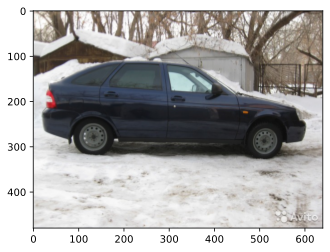

(640, 480)

In [ ]:
image = PIL.Image.open(PATH+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

Запомним размер картинок

Посмотрим как выглядят наши картинке на выходе train_generator, c hfpvthjv 71х71

Пример картинок из train_generator


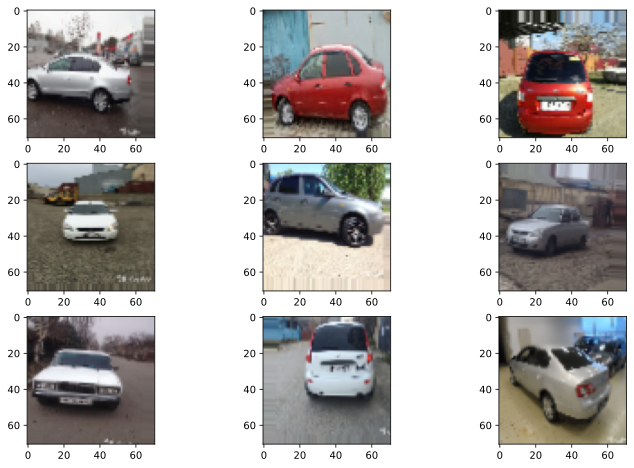

In [ ]:
from skimage import io

def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()

x,y = train_generator.next()
print('Пример картинок из train_generator')
plt.figure(figsize=(12,8))

for i in range(0,9):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

# Построение модели

Для построения модели возьмем предобученную сеть Xception из модуля keras.applications.

Базовая модель: для ускорения экспериментов я уменьшил насколько возможно размер картинок подающихся  на вход нейронной сети и увеличил батч до максимального, который влез на GPU. Для сабмитов конечно буду размер картинок потом увеличивать.

In [ ]:
K.clear_session() # очищаем сессию keras

In [ ]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.
# Изображения подаваемые в сеть уменьшил до 128 чтобы сократить время обучения
EPOCHS               = 5  # эпох на обучение
BATCH_SIZE           = 128 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 71 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '/content/drive/MyDrive/Ford_vs_Ferrari/'
PATH = "../working/car/" # рабочая директория

RANDOM_SEED =42

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=False)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VAL_SPLIT,
)

test_datagen = ImageDataGenerator(rescale=1. / 255)





In [ ]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data




test_generator = val_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

In [ ]:
 x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = BatchNormalization()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
# x = BatchNormalization()(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

In [ ]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
104/104 [==============================] - 122s 1s/step - loss: 2.1473 - accuracy: 0.1959 - val_loss: 1.9552 - val_accuracy: 0.2744

Epoch 00001: saving model to best_model.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
104/104 [==============================] - 114s 1s/step - loss: 1.6369 - accuracy: 0.4092 - val_loss: 1.4290 - val_accuracy: 0.4813

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
104/104 [==============================] - 114s 1s/step - loss: 1.1667 - accuracy: 0.5821 - val_loss: 1.0899 - val_accuracy: 0.6080

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
104/104 [==============================] - 114s 1s/step - loss: 0.8831 - accuracy: 0.6820 - val_loss: 0.9937 - val_accuracy: 0.6518

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
104/104 [==============================] - 114s 1s/step - loss: 0.6767 - accuracy: 0.7542 - val_loss: 0.9595 - val_accuracy: 0.6805

Epoch 00005: saving model to best_model.hdf5


In [ ]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


19/19 [==============================] - 11s 592ms/step - loss: 0.9595 - accuracy: 0.6805
Accuracy: 68.05%


# Accuracy =68.50% - это будет наша точка отсчета

Посмотрим на графики обучения:

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

# Добавим новые аугментации и посмотрим как это повлияет на качество:

In [ ]:
K.clear_session() # очищаем сессию keras

In [ ]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.
# Изображения подаваемые в сеть уменьшил до 128 чтобы сократить время обучения
EPOCHS               = 5  # эпох на обучение
BATCH_SIZE           = 128 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 71 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '/content/drive/MyDrive/Ford_vs_Ferrari/'
PATH = "../working/car/" # рабочая директория

RANDOM_SEED =42

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1/255,
                                   validation_split = VAL_SPLIT,
                                   rotation_range = 10, 
                                   width_shift_range = 0.1, 
                                   height_shift_range = 0.1, 
                                   shear_range = 0.1, 
                                   zoom_range = 0.1, 
                                   horizontal_flip=True, 
                                   fill_mode='nearest')
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
)

test_datagen = ImageDataGenerator(rescale = 1/255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data




test_generator = val_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 13232 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Found 6675 validated image filenames.


In [ ]:
# посмотрим результаты как изменились картинки после аугментации
train_generator.show_data(rows=3, cols=5)

In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

In [ ]:
 x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = BatchNormalization()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
# x = BatchNormalization()(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

In [ ]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
104/104 [==============================] - 128s 1s/step - loss: 2.1447 - accuracy: 0.1920 - val_loss: 1.9542 - val_accuracy: 0.2898

Epoch 00001: saving model to best_model.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
104/104 [==============================] - 120s 1s/step - loss: 1.6724 - accuracy: 0.3937 - val_loss: 1.5022 - val_accuracy: 0.4419

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
104/104 [==============================] - 118s 1s/step - loss: 1.2055 - accuracy: 0.5641 - val_loss: 1.1479 - val_accuracy: 0.5815

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
104/104 [==============================] - 118s 1s/step - loss: 0.9488 - accuracy: 0.6559 - val_loss: 0.9542 - val_accuracy: 0.6594

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
104/104 [==============================] - 121s 1s/step - loss: 0.7736 - accuracy: 0.7176 - val_loss: 0.8315 - val_accuracy: 0.7096

Epoch 00005: saving model to best_model.hdf5


In [ ]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


25/25 [==============================] - 16s 631ms/step - loss: 0.8315 - accuracy: 0.7096
Accuracy: 70.96%


Accuracy: 70.96% аугментации дали прирост на 2% примерно!

# Поиграем с набором аугментаций:

In [ ]:
K.clear_session() # очищаем сессию keras

In [ ]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.
# Изображения подаваемые в сеть уменьшил до 128 чтобы сократить время обучения
EPOCHS               = 5  # эпох на обучение
BATCH_SIZE           = 128 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 71 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '/content/drive/MyDrive/Ford_vs_Ferrari/'
PATH = "../working/car/" # рабочая директория

RANDOM_SEED =42

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = VAL_SPLIT,
                                   rotation_range = 5, 
                                   width_shift_range = 0.1, 
                                   height_shift_range = 0.1, 
                                   #shear_range = 0.1, 
                                   #zoom_range = 0.1,
                                   #brightness_range=[0.2,1.0], 
                                   horizontal_flip=False 
                                   )
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
)

test_datagen = ImageDataGenerator(rescale = 1/255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data




test_generator = val_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 13232 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Found 6675 validated image filenames.


In [ ]:
# посмотрим результаты как изменились картинки после аугментации
train_generator.show_data(rows=3, cols=5)

In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

In [ ]:
 x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = BatchNormalization()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
# x = BatchNormalization()(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

In [ ]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
104/104 [==============================] - 126s 1s/step - loss: 2.1347 - accuracy: 0.2084 - val_loss: 1.9170 - val_accuracy: 0.2879

Epoch 00001: saving model to best_model.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
104/104 [==============================] - 115s 1s/step - loss: 1.5383 - accuracy: 0.4443 - val_loss: 1.3227 - val_accuracy: 0.5240

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
104/104 [==============================] - 114s 1s/step - loss: 1.0968 - accuracy: 0.5968 - val_loss: 1.0351 - val_accuracy: 0.6166

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
104/104 [==============================] - 115s 1s/step - loss: 0.8420 - accuracy: 0.6933 - val_loss: 0.9208 - val_accuracy: 0.6739

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
104/104 [==============================] - 116s 1s/step - loss: 0.6552 - accuracy: 0.7630 - val_loss: 0.8048 - val_accuracy: 0.7163

Epoch 00005: saving model to best_model.hdf5


In [ ]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


25/25 [==============================] - 15s 599ms/step - loss: 0.8048 - accuracy: 0.7163
Accuracy: 71.63%


# Вот, это пока лучший вариант с аугментациями! надо на его примере сделать submit 71.63%

In [ ]:
Пробуем с аугментациями с лучших работ с kaggle

In [ ]:
K.clear_session() # очищаем сессию keras

In [ ]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.
# Изображения подаваемые в сеть уменьшил до 128 чтобы сократить время обучения
EPOCHS               = 5  # эпох на обучение
BATCH_SIZE           = 128 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.05 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 71 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '/content/drive/MyDrive/Ford_vs_Ferrari/'
PATH = "../working/car/" # рабочая директория

RANDOM_SEED =42

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = VAL_SPLIT,
                                   rotation_range = 5, 
                                   width_shift_range = 0.1, 
                                   height_shift_range = 0.1, 
                                   #shear_range = 0.1, 
                                   #zoom_range = 0.1,
                                   #brightness_range=[0.2,1.0], 
                                   horizontal_flip=True,
                                   brightness_range=[0.5,0.5],
                                   
                                   shear_range = 0.2,
                                   zoom_range = 0.1

                                   )
# Надо проверить еще такие настройки аугментации:
# настройки для аугментации
#WIDTH_SHIFT_RANGE    = 0.1
#HEIGHT_SHIFT_RANGE   = 0.1
#HORIZONTAL_FLIP      = True
#VERTICAL_FLIP        = False
#ROTATION_RANGE       = 10
#BRIGHTNES_RANGE      = (0.5, 1.5)
#RESCALE              = 1
#SHEAR_RANGE          = 0.2
#ZOOM_RANGE           = 0.1
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
)

test_datagen = ImageDataGenerator(rescale = 1/255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data




test_generator = val_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 14788 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Found 6675 validated image filenames.


In [ ]:
# посмотрим результаты как изменились картинки после аугментации
train_generator.show_data(rows=3, cols=5)

In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

In [ ]:
 x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = BatchNormalization()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
# x = BatchNormalization()(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

In [ ]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
116/116 [==============================] - 145s 1s/step - loss: 2.1409 - accuracy: 0.1913 - val_loss: 1.9487 - val_accuracy: 0.2773

Epoch 00001: saving model to best_model.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
116/116 [==============================] - 137s 1s/step - loss: 1.6383 - accuracy: 0.4087 - val_loss: 1.5210 - val_accuracy: 0.4468

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
116/116 [==============================] - 137s 1s/step - loss: 1.1405 - accuracy: 0.5832 - val_loss: 1.7029 - val_accuracy: 0.4172

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
116/116 [==============================] - 137s 1s/step - loss: 0.8789 - accuracy: 0.6791 - val_loss: 1.9670 - val_accuracy: 0.3619

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
116/116 [==============================] - 139s 1s/step - loss: 0.7180 - accuracy: 0.7395 - val_loss: 2.4192 - val_accuracy: 0.3409

Epoch 00005: saving model to best_model.hdf5


In [ ]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


25/25 [==============================] - 16s 621ms/step - loss: 2.4192 - accuracy: 0.3409
Accuracy: 34.09%


In [ ]:
Отрицательный результат(

# Вывод по использованию аугментаций: 
Для обучения нейронных сетей нужны большие наборы данных. Аугментация позволяет искусственно увеличить количество данных. Как видно из экспериментов аугментация может дать очень ощутимый прирост точности модели, главное грамотно подобрать параметры.

# Теперь посмотрим как влияет VAL_SPLIT 
сделаем его 0.2 вместо 0.15:

In [ ]:
K.clear_session() # очищаем сессию keras

In [ ]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.
# Изображения подаваемые в сеть уменьшил до 128 чтобы сократить время обучения
EPOCHS               = 5  # эпох на обучение
BATCH_SIZE           = 128 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.2 # сколько данных выделяем на тест = 20%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 71 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '/content/drive/MyDrive/Ford_vs_Ferrari/'
PATH = "../working/car/" # рабочая директория

RANDOM_SEED =42

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=False)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VAL_SPLIT,
)

test_datagen = ImageDataGenerator(rescale=1. / 255)





In [ ]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data




test_generator = val_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Found 6675 validated image filenames.


In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

In [ ]:
 x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = BatchNormalization()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
# x = BatchNormalization()(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

In [ ]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
98/98 [==============================] - 119s 1s/step - loss: 2.2022 - accuracy: 0.1658 - val_loss: 2.0529 - val_accuracy: 0.2467

Epoch 00001: saving model to best_model.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
98/98 [==============================] - 112s 1s/step - loss: 1.6668 - accuracy: 0.3964 - val_loss: 1.4441 - val_accuracy: 0.4786

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
98/98 [==============================] - 113s 1s/step - loss: 1.1704 - accuracy: 0.5767 - val_loss: 1.1805 - val_accuracy: 0.5770

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
98/98 [==============================] - 112s 1s/step - loss: 0.8760 - accuracy: 0.6804 - val_loss: 1.0228 - val_accuracy: 0.6381

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
98/98 [==============================] - 111s 1s/step - loss: 0.6736 - accuracy: 0.7571 - val_loss: 1.0134 - val_accuracy: 0.6587

Epoch 00005: saving model to best_model.hdf5


In [ ]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


25/25 [==============================] - 15s 609ms/step - loss: 1.0134 - accuracy: 0.6587
Accuracy: 65.87%


Accuracy: 65.87% это пониже чем было, продолжим эксперименты

Теперь посмотрим как влияет VAL_SPLIT = 0.05 вместо 0.15:

In [ ]:
K.clear_session() # очищаем сессию keras

In [ ]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.
# Изображения подаваемые в сеть уменьшил до 128 чтобы сократить время обучения
EPOCHS               = 5  # эпох на обучение
BATCH_SIZE           = 128 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.05 # сколько данных выделяем на тест = 5%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 71 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '/content/drive/MyDrive/Ford_vs_Ferrari/'
PATH = "../working/car/" # рабочая директория

RANDOM_SEED =42

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=False)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VAL_SPLIT,
)

test_datagen = ImageDataGenerator(rescale=1. / 255)





In [ ]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data




test_generator = val_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 14788 images belonging to 10 classes.
Found 773 images belonging to 10 classes.
Found 6675 validated image filenames.


In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

In [ ]:
 x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = BatchNormalization()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
# x = BatchNormalization()(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

In [ ]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
116/116 [==============================] - 131s 1s/step - loss: 2.1286 - accuracy: 0.1961 - val_loss: 1.9635 - val_accuracy: 0.2691

Epoch 00001: saving model to best_model.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
116/116 [==============================] - 120s 1s/step - loss: 1.5622 - accuracy: 0.4306 - val_loss: 1.4072 - val_accuracy: 0.4968

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
116/116 [==============================] - 121s 1s/step - loss: 1.0814 - accuracy: 0.6031 - val_loss: 1.2742 - val_accuracy: 0.5537

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
116/116 [==============================] - 121s 1s/step - loss: 0.8109 - accuracy: 0.7031 - val_loss: 0.9890 - val_accuracy: 0.6494

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
116/116 [==============================] - 119s 1s/step - loss: 0.6204 - accuracy: 0.7768 - val_loss: 0.9302 - val_accuracy: 0.7076

Epoch 00005: saving model to best_model.hdf5


In [ ]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


7/7 [==============================] - 4s 529ms/step - loss: 0.9302 - accuracy: 0.7076
Accuracy: 70.76%


Accuracy: 70.76%,
VAL_SPLIT = 0.05, дает лучший результат, будем в дальнейшем использовать его!

# Вывод по размеру VAL_SPLIT:
Из экспериментов видно, что лучшие показатели модель выдала при разбиении данных на трейновые и валидационные в соотношении 95/5. Думаю так получается, так как нейросеть таким образом получает больше данных для обучения, а это критично важно. Чем больше данных для обучения, тем лучше обучится сеть.

# Теперь поработаем с learning_rate,
 увеличим его на порядок и используем в дальнейшем лучший VAL_SPLIT = 0.05

In [ ]:
K.clear_session() # очищаем сессию keras

In [ ]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.
# Изображения подаваемые в сеть уменьшил до 128 чтобы сократить время обучения
EPOCHS               = 5  # эпох на обучение
BATCH_SIZE           = 128 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-3
VAL_SPLIT            = 0.05 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 71 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '/content/drive/MyDrive/Ford_vs_Ferrari/'
PATH = "../working/car/" # рабочая директория

RANDOM_SEED =42

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=False)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VAL_SPLIT,
)

test_datagen = ImageDataGenerator(rescale=1. / 255)





In [ ]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data




test_generator = val_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

In [ ]:
 x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = BatchNormalization()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
# x = BatchNormalization()(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

In [ ]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
104/104 [==============================] - 125s 1s/step - loss: 2.1521 - accuracy: 0.1879 - val_loss: 1.9968 - val_accuracy: 0.2628

Epoch 00001: saving model to best_model.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
104/104 [==============================] - 115s 1s/step - loss: 1.6522 - accuracy: 0.3955 - val_loss: 1.4614 - val_accuracy: 0.4534

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
104/104 [==============================] - 114s 1s/step - loss: 1.1747 - accuracy: 0.5697 - val_loss: 1.1740 - val_accuracy: 0.5728

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
104/104 [==============================] - 116s 1s/step - loss: 0.8816 - accuracy: 0.6780 - val_loss: 1.0447 - val_accuracy: 0.6389

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
104/104 [==============================] - 116s 1s/step - loss: 0.6734 - accuracy: 0.7549 - val_loss: 1.0183 - val_accuracy: 0.6518

Epoch 00005: saving model to best_model.hdf5


In [ ]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


19/19 [==============================] - 12s 597ms/step - loss: 1.0183 - accuracy: 0.6518
Accuracy: 65.18%


Получилось, что learning_rate =  1e-3 ухудшил модель: accuracy = 65.18%

Теперь уменьшим learning_rate  на порядок от базового 1е-5

In [ ]:
K.clear_session() # очищаем сессию keras

In [ ]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.
# Изображения подаваемые в сеть уменьшил до 128 чтобы сократить время обучения
EPOCHS               = 5  # эпох на обучение
BATCH_SIZE           = 128 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-5
VAL_SPLIT            = 0.05 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 71 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '/content/drive/MyDrive/Ford_vs_Ferrari/'
PATH = "../working/car/" # рабочая директория

RANDOM_SEED =42

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=False)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=VAL_SPLIT,
)

test_datagen = ImageDataGenerator(rescale=1. / 255)





In [ ]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data




test_generator = val_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

In [ ]:
 x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = BatchNormalization()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
# x = BatchNormalization()(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

In [ ]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
104/104 [==============================] - 123s 1s/step - loss: 2.3019 - accuracy: 0.1159 - val_loss: 2.2944 - val_accuracy: 0.1103

Epoch 00001: saving model to best_model.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
104/104 [==============================] - 117s 1s/step - loss: 2.2625 - accuracy: 0.1385 - val_loss: 2.2424 - val_accuracy: 0.1481

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
104/104 [==============================] - 117s 1s/step - loss: 2.1995 - accuracy: 0.1606 - val_loss: 2.1655 - val_accuracy: 0.1692

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
104/104 [==============================] - 117s 1s/step - loss: 2.1341 - accuracy: 0.1942 - val_loss: 2.1065 - val_accuracy: 0.2070

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
104/104 [==============================] - 117s 1s/step - loss: 2.0769 - accuracy: 0.2285 - val_loss: 2.0501 - val_accuracy: 0.2400

Epoch 00005: saving model to best_model.hdf5


In [ ]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


19/19 [==============================] - 12s 609ms/step - loss: 2.0501 - accuracy: 0.2400
Accuracy: 24.00%


Learning rate =1e-5   так же сильно ухудшил accuracy

# Вывод по learning_rate:
Лучшие результаты показывает применение learning_rate=1e-4

Проверим еще раз модель с лучшими настройками: VAL_SPLIT=0.
05,LR=1e-4 и лучшими на данный момент аугментациями:

In [ ]:
K.clear_session() # очищаем сессию keras

In [ ]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.
# Изображения подаваемые в сеть уменьшил до 128 чтобы сократить время обучения
EPOCHS               = 5  # эпох на обучение
BATCH_SIZE           = 128 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.05 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 71 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '/content/drive/MyDrive/Ford_vs_Ferrari/'
PATH = "../working/car/" # рабочая директория

RANDOM_SEED =42

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = VAL_SPLIT,
                                   rotation_range = 5, 
                                   width_shift_range = 0.1, 
                                   height_shift_range = 0.1, 
                                   #shear_range = 0.1, 
                                   #zoom_range = 0.1,
                                   #brightness_range=[0.2,1.0], 
                                   horizontal_flip=False 
                                   )
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
)

test_datagen = ImageDataGenerator(rescale = 1/255)





In [ ]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data




test_generator = val_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 14788 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Found 6675 validated image filenames.


In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

In [ ]:
 x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = BatchNormalization()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
# x = BatchNormalization()(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

In [ ]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
116/116 [==============================] - 141s 1s/step - loss: 2.1388 - accuracy: 0.1923 - val_loss: 1.9293 - val_accuracy: 0.2940

Epoch 00001: saving model to best_model.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
116/116 [==============================] - 135s 1s/step - loss: 1.5309 - accuracy: 0.4440 - val_loss: 1.2654 - val_accuracy: 0.5465

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
116/116 [==============================] - 135s 1s/step - loss: 1.0456 - accuracy: 0.6192 - val_loss: 0.8532 - val_accuracy: 0.7034

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
116/116 [==============================] - 134s 1s/step - loss: 0.7808 - accuracy: 0.7171 - val_loss: 0.7014 - val_accuracy: 0.7527

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
116/116 [==============================] - 134s 1s/step - loss: 0.5949 - accuracy: 0.7889 - val_loss: 0.4984 - val_accuracy: 0.8244

Epoch 00005: saving model to best_model.hdf5


In [ ]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


25/25 [==============================] - 16s 621ms/step - loss: 0.4984 - accuracy: 0.8244
Accuracy: 82.44%


# Ок все нормально. Это пока лучшая комбинация, которой удалось добиться! Accuracy: 82.44%

Тест сети на полноразмерных картинках размером 224х224, с сабмитом и лучшими параметрами аугментаций, VAL_SPLIT и LR

In [ ]:
K.clear_session() # очищаем сессию keras

In [ ]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.
# Изображения подаваемые в сеть уменьшил до 128 чтобы сократить время обучения
EPOCHS               = 5  # эпох на обучение
BATCH_SIZE           = 64 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.05 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '/content/drive/MyDrive/Ford_vs_Ferrari/'
PATH = "../working/car/" # рабочая директория

RANDOM_SEED =42

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = VAL_SPLIT,
                                   rotation_range = 5, 
                                   width_shift_range = 0.1, 
                                   height_shift_range = 0.1, 
                                   #shear_range = 0.1, 
                                   #zoom_range = 0.1,
                                   #brightness_range=[0.2,1.0], 
                                   horizontal_flip=False 
                                   )
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
)

test_datagen = ImageDataGenerator(rescale = 1/255)





In [ ]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data




test_generator = val_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 14788 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Found 6675 validated image filenames.


In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

In [ ]:
 x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = BatchNormalization()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
# x = BatchNormalization()(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

In [ ]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
232/232 [==============================] - 652s 3s/step - loss: 0.7899 - accuracy: 0.7209 - val_loss: 0.2438 - val_accuracy: 0.9157

Epoch 00001: saving model to best_model.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
232/232 [==============================] - 645s 3s/step - loss: 0.1875 - accuracy: 0.9344 - val_loss: 0.1205 - val_accuracy: 0.9604

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
232/232 [==============================] - 644s 3s/step - loss: 0.1096 - accuracy: 0.9607 - val_loss: 0.1094 - val_accuracy: 0.9598

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
232/232 [==============================] - 644s 3s/step - loss: 0.0717 - accuracy: 0.9734 - val_loss: 0.1478 - val_accuracy: 0.9566

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
232/232 [==============================] - 641s 3s/step - loss: 0.0573 - accuracy: 0.9796 - val_loss: 0.0917 - val_accuracy: 0.9762

Epoch 00005: saving model to best_model.hdf5


In [ ]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


49/49 [==============================] - 29s 587ms/step - loss: 0.0917 - accuracy: 0.9762
Accuracy: 97.62%


Пока лучший результат 97.62%

Предскажем на тестовых данных:

In [ ]:
test_sub_generator.samples

6675

In [ ]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


105/105 [==============================] - 62s 581ms/step


In [ ]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

Save submit


In [ ]:
from google.colab import files
files.download('submission.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Лучший результат, который дает эта комбинация аугментаций и VAL_SPLIT=0.05, и LR=1e-4, на тестовых данных 0.93528

# Возьмем базовые настройки и попробуем использовать другую нейронную сеть для обучения модели:

In [ ]:
K.clear_session()

In [ ]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.
# Изображения подаваемые в сеть уменьшил до 128 чтобы сократить время обучения
EPOCHS               = 5  # эпох на обучение
BATCH_SIZE           = 128 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 75 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '/content/drive/MyDrive/Ford_vs_Ferrari/'
PATH = "../working/car/" # рабочая директория

RANDOM_SEED =42

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=False)



test_datagen = ImageDataGenerator(rescale=1. / 255)





In [ ]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data



test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


In [ ]:
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape = input_shape)

219070464/219055592 [==============================] - 3s 0us/step


In [ ]:
 x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = BatchNormalization()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
# x = BatchNormalization()(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

In [ ]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
104/104 [==============================] - 191s 1s/step - loss: 2.2319 - accuracy: 0.1917 - val_loss: 2.0859 - val_accuracy: 0.2366

Epoch 00001: saving model to best_model.hdf5
Epoch 2/5
104/104 [==============================] - 132s 1s/step - loss: 1.7650 - accuracy: 0.3700 - val_loss: 1.5919 - val_accuracy: 0.4392

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
104/104 [==============================] - 127s 1s/step - loss: 1.3842 - accuracy: 0.5022 - val_loss: 2.5957 - val_accuracy: 0.5213

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
104/104 [==============================] - 127s 1s/step - loss: 1.1111 - accuracy: 0.6011 - val_loss: 6.2013 - val_accuracy: 0.5891

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
104/104 [==============================] - 127s 1s/step - loss: 0.8810 - accuracy: 0.6877 - val_loss: 5.8882 - val_accuracy: 0.6101

Epoch 00005: saving model to best_model.hdf5


In [ ]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


19/19 [==============================] - 16s 848ms/step - loss: 10.8832 - accuracy: 0.6114
Accuracy: 61.14%


Итак  сеть InceptionResNetV2 дала Accuracy: 61.14% это меньше чем Accuracy: 64.62% у Xception. Эту сеть отметаем. Попробуем еще одну: ResNet152V2

In [ ]:
K.clear_session()

In [ ]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.
# Изображения подаваемые в сеть уменьшил до 128 чтобы сократить время обучения
EPOCHS               = 5  # эпох на обучение
BATCH_SIZE           = 128 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 71 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '/content/drive/MyDrive/Ford_vs_Ferrari/'
PATH = "../working/car/" # рабочая директория

RANDOM_SEED =42

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=False)



test_datagen = ImageDataGenerator(rescale=1. / 255)





In [ ]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data



test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


In [ ]:
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape = input_shape)

234561536/234545216 [==============================] - 3s 0us/step


In [ ]:
 x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = BatchNormalization()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
# x = BatchNormalization()(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

In [ ]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
104/104 [==============================] - 176s 1s/step - loss: 2.2756 - accuracy: 0.1750 - val_loss: 2.2084 - val_accuracy: 0.2289

Epoch 00001: saving model to best_model.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
104/104 [==============================] - 147s 1s/step - loss: 1.8297 - accuracy: 0.3267 - val_loss: 1.8336 - val_accuracy: 0.3671

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
104/104 [==============================] - 147s 1s/step - loss: 1.4429 - accuracy: 0.4655 - val_loss: 1.5388 - val_accuracy: 0.4676

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
104/104 [==============================] - 148s 1s/step - loss: 1.1291 - accuracy: 0.5881 - val_loss: 1.2817 - val_accuracy: 0.5505

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
104/104 [==============================] - 148s 1s/step - loss: 0.9141 - accuracy: 0.6694 - val_loss: 1.2691 - val_accuracy: 0.5668

Epoch 00005: saving model to best_model.hdf5


In [ ]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


19/19 [==============================] - 18s 906ms/step - loss: 1.2486 - accuracy: 0.5689
Accuracy: 56.89%


Итак сеть ResNet152V2 дала Accuracy: 56.89% это меньше чем Accuracy: 64.62% у Xception. Эту сеть отметаем тоже, так как самый низкий результат

Попробуем сеть EfficientNetB3

In [ ]:
K.clear_session()

In [ ]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.
# Изображения подаваемые в сеть уменьшил до 128 чтобы сократить время обучения
EPOCHS               = 5  # эпох на обучение
BATCH_SIZE           = 128 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 75 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '/content/drive/MyDrive/Ford_vs_Ferrari/'
PATH = "../working/car/" # рабочая директория

RANDOM_SEED =42

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=False)



test_datagen = ImageDataGenerator(rescale=1. / 255)





In [ ]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data



test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


In [ ]:
base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape = input_shape)

43950080/43941136 [==============================] - 1s 0us/step


In [ ]:
 x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = BatchNormalization()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
# x = BatchNormalization()(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

In [ ]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
104/104 [==============================] - 148s 1s/step - loss: 2.3537 - accuracy: 0.1233 - val_loss: 2.3458 - val_accuracy: 0.0936

Epoch 00001: saving model to best_model.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
104/104 [==============================] - 123s 1s/step - loss: 2.2204 - accuracy: 0.1753 - val_loss: 2.3275 - val_accuracy: 0.1048

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
104/104 [==============================] - 122s 1s/step - loss: 2.0829 - accuracy: 0.2359 - val_loss: 2.3634 - val_accuracy: 0.1000

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
104/104 [==============================] - 122s 1s/step - loss: 1.9445 - accuracy: 0.2898 - val_loss: 2.3313 - val_accuracy: 0.1168

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
104/104 [==============================] - 123s 1s/step - loss: 1.7804 - accuracy: 0.3499 - val_loss: 2.2693 - val_accuracy: 0.1387

Epoch 00005: saving model to best_model.hdf5


In [ ]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


19/19 [==============================] - 15s 806ms/step - loss: 2.2696 - accuracy: 0.1211
Accuracy: 12.11%


Результат использования EfficientNetB3 очень низкий Accuracy всего 12.11%. Не буду использовать эту сеть для дальнейших экспериментов

# Вывод по сетям:
Лучшие показатели у предложенной в бэйслайне сети Xception. Из экспериментов видно, что выбор нейронной сети под конкретную задачу имеет значение и оказывает серьезное влияние на результат. 





# Попробуем реализовать батч-нормализацию ради эксперимента, посмотрим как как повлияет на метрику:


In [ ]:
K.clear_session()

In [ ]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.
# Изображения подаваемые в сеть уменьшил до 128 чтобы сократить время обучения
EPOCHS               = 5  # эпох на обучение
BATCH_SIZE           = 128 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 71 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '/content/drive/MyDrive/Ford_vs_Ferrari/'
PATH = "../working/car/" # рабочая директория

RANDOM_SEED =42

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=False)



test_datagen = ImageDataGenerator(rescale=1. / 255)





In [ ]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data



test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
 x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)

x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

In [ ]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
104/104 [==============================] - 137s 1s/step - loss: 2.3577 - accuracy: 0.1542 - val_loss: 2.2163 - val_accuracy: 0.2074

Epoch 00001: saving model to best_model.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
104/104 [==============================] - 125s 1s/step - loss: 1.8873 - accuracy: 0.3150 - val_loss: 1.9809 - val_accuracy: 0.3405

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
104/104 [==============================] - 124s 1s/step - loss: 1.4823 - accuracy: 0.4548 - val_loss: 1.7734 - val_accuracy: 0.4457

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
104/104 [==============================] - 127s 1s/step - loss: 1.1839 - accuracy: 0.5681 - val_loss: 1.4164 - val_accuracy: 0.5603

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
104/104 [==============================] - 128s 1s/step - loss: 0.9460 - accuracy: 0.6587 - val_loss: 1.1871 - val_accuracy: 0.5861

Epoch 00005: saving model to best_model.hdf5


In [ ]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


19/19 [==============================] - 16s 839ms/step - loss: 1.1728 - accuracy: 0.6015
Accuracy: 60.15%


# Вывод по добавлению батч-нормализации в голову модели:
 добавление батч-нормализации только ухудшило метрику. К тому же была получена информация, что в голову батч-нормализацию не принято добавлять. Что же, отрицательный результат - тоже результат.

# Проведем эксперимент с количеством эпох обучения.Проверим, когда наступит переобучение,если взять например 12 эпох

In [ ]:
K.clear_session() # очищаем сессию keras

In [ ]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.
# Изображения подаваемые в сеть уменьшил до 128 чтобы сократить время обучения
EPOCHS               = 12 # эпох на обучение
BATCH_SIZE           = 128 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.05 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 71 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '/content/drive/MyDrive/Ford_vs_Ferrari/'
PATH = "../working/car/" # рабочая директория

RANDOM_SEED =42

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = VAL_SPLIT,
                                   rotation_range = 5, 
                                   width_shift_range = 0.1, 
                                   height_shift_range = 0.1, 
                                   #shear_range = 0.1, 
                                   #zoom_range = 0.1,
                                   #brightness_range=[0.2,1.0], 
                                   horizontal_flip=False 
                                   )
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
)

test_datagen = ImageDataGenerator(rescale = 1/255)





In [ ]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data



test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 14788 images belonging to 10 classes.
Found 773 images belonging to 10 classes.
Found 6675 validated image filenames.


In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

In [ ]:
 x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = BatchNormalization()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
# x = BatchNormalization()(x)
x = Dropout(0.25)(x)
#x = Dense(256, activation='relu')(x) добавлял еще один dense слой но ухудшило картину
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

In [ ]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/12
116/116 [==============================] - 138s 1s/step - loss: 2.1230 - accuracy: 0.2065 - val_loss: 1.9353 - val_accuracy: 0.3040

Epoch 00001: saving model to best_model.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/12
116/116 [==============================] - 124s 1s/step - loss: 1.5267 - accuracy: 0.4446 - val_loss: 1.3554 - val_accuracy: 0.5032

Epoch 00002: saving model to best_model.hdf5
Epoch 3/12
116/116 [==============================] - 126s 1s/step - loss: 1.0750 - accuracy: 0.6085 - val_loss: 1.1397 - val_accuracy: 0.5692

Epoch 00003: saving model to best_model.hdf5
Epoch 4/12
116/116 [==============================] - 124s 1s/step - loss: 0.8156 - accuracy: 0.7043 - val_loss: 1.0361 - val_accuracy: 0.6455

Epoch 00004: saving model to best_model.hdf5
Epoch 5/12
116/116 [==============================] - 124s 1s/step - loss: 0.6307 - accuracy: 0.7725 - val_loss: 0.9807 - val_accuracy: 0.6662

Epoch 00005: saving model to best_model.hdf5
Epoch 6/12
116/116 [==============================] - 124s 1s/step - loss: 0.5030 - accuracy: 0.8231 - val_loss: 1.0376 - val_accuracy: 0.6675

Epoch 00006: saving model to best_model.hdf5
Epoch 7/12
116/116 [==============================] - 1

In [ ]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


7/7 [==============================] - 5s 688ms/step - loss: 1.1009 - accuracy: 0.7076
Accuracy: 70.76%


Посмотрим на графики обучения:

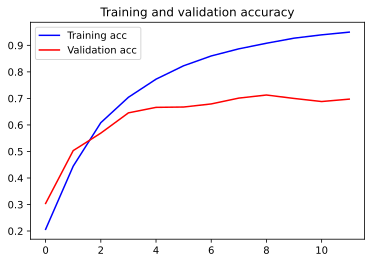

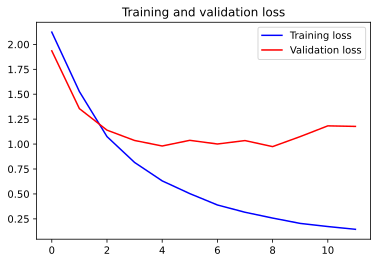

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

Что и требовалось доказать! Эпохи после наступления момента переобучения только отнимают машинное время и ухудшают результат

# Применим  finetuning :

Будем сравнивать его результаты с лучшей моделью, та которая с Accuracy: 71.63%

In [ ]:
K.clear_session() # очищаем сессию keras

In [ ]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.
# Изображения подаваемые в сеть уменьшил до 128 чтобы сократить время обучения
EPOCHS               = 5  # эпох на обучение
BATCH_SIZE           = 128 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 71 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '/content/drive/MyDrive/Ford_vs_Ferrari/'
PATH = "../working/car/" # рабочая директория

RANDOM_SEED =42

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split = VAL_SPLIT,
                                   rotation_range = 5, 
                                   width_shift_range = 0.1, 
                                   height_shift_range = 0.1, 
                                   #shear_range = 0.1, 
                                   #zoom_range = 0.1,
                                   #brightness_range=[0.2,1.0], 
                                   horizontal_flip=False 
                                   )
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
)

test_datagen = ImageDataGenerator(rescale = 1/255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data




test_generator = val_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 13232 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Found 6675 validated image filenames.


Заморозим все слои Xception и будем обучать только "голову"

In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)
base_model.trainable = False

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
LR =0.001

In [ ]:
 x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = BatchNormalization()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
# x = BatchNormalization()(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

In [ ]:
len(model.trainable_variables)

4

In [ ]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
104/104 [==============================] - 143s 1s/step - loss: 2.1550 - accuracy: 0.2140 - val_loss: 2.0044 - val_accuracy: 0.2564

Epoch 00001: saving model to best_model.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
104/104 [==============================] - 101s 973ms/step - loss: 2.0109 - accuracy: 0.2653 - val_loss: 1.9499 - val_accuracy: 0.2840

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
104/104 [==============================] - 101s 967ms/step - loss: 1.9620 - accuracy: 0.2879 - val_loss: 1.8858 - val_accuracy: 0.3223

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
104/104 [==============================] - 102s 985ms/step - loss: 1.9210 - accuracy: 0.3039 - val_loss: 1.9047 - val_accuracy: 0.3085

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
104/104 [==============================] - 104s 996ms/step - loss: 1.8958 - accuracy: 0.3134 - val_loss: 1.8467 - val_accuracy: 0.3409

Epoch 00005: saving model to best_model.hdf5


In [ ]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


25/25 [==============================] - 16s 639ms/step - loss: 1.8467 - accuracy: 0.3409
Accuracy: 34.09%


Посчитаем сколько слоев в базовой модели:

In [ ]:
print("number of layers in base model:",len(base_model.layers))

number of layers in base model: 132


Разморозим в модели слои с 70-го и уменьшим на порядок шаг обучения

In [ ]:
base_model.trainable = True
fine_tune_at  = 70
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False


In [ ]:
LR = 0.0001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])


In [ ]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
104/104 [==============================] - 118s 1s/step - loss: 1.9322 - accuracy: 0.3048 - val_loss: 1.8334 - val_accuracy: 0.3757

Epoch 00001: saving model to best_model.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
104/104 [==============================] - 110s 1s/step - loss: 1.5796 - accuracy: 0.4337 - val_loss: 1.5271 - val_accuracy: 0.4657

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
104/104 [==============================] - 111s 1s/step - loss: 1.3496 - accuracy: 0.5078 - val_loss: 1.4402 - val_accuracy: 0.4950

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
104/104 [==============================] - 110s 1s/step - loss: 1.1734 - accuracy: 0.5753 - val_loss: 1.3202 - val_accuracy: 0.5484

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
104/104 [==============================] - 111s 1s/step - loss: 1.0396 - accuracy: 0.6285 - val_loss: 1.2077 - val_accuracy: 0.5831

Epoch 00005: saving model to best_model.hdf5


In [ ]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


25/25 [==============================] - 16s 638ms/step - loss: 1.2077 - accuracy: 0.5831
Accuracy: 58.31%


Разморозим еще ряд слоев с 30 го и еще уменьшим шаг обучения

In [ ]:
base_model.trainable = True
fine_tune_at  = 30
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
LR = 0.00001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

In [ ]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
104/104 [==============================] - 122s 1s/step - loss: 1.2315 - accuracy: 0.5605 - val_loss: 1.2293 - val_accuracy: 0.5851

Epoch 00001: saving model to best_model.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
104/104 [==============================] - 114s 1s/step - loss: 1.1017 - accuracy: 0.6038 - val_loss: 1.2053 - val_accuracy: 0.5796

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
104/104 [==============================] - 115s 1s/step - loss: 1.0315 - accuracy: 0.6280 - val_loss: 1.1882 - val_accuracy: 0.5925

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
104/104 [==============================] - 115s 1s/step - loss: 0.9662 - accuracy: 0.6487 - val_loss: 1.1654 - val_accuracy: 0.6005

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
104/104 [==============================] - 115s 1s/step - loss: 0.9442 - accuracy: 0.6592 - val_loss: 1.1388 - val_accuracy: 0.6089

Epoch 00005: saving model to best_model.hdf5


In [ ]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


25/25 [==============================] - 16s 648ms/step - loss: 1.1388 - accuracy: 0.6089
Accuracy: 60.89%


Разморозим все слои и посмотрим что вышло, не завбываем уменьшить еще на порядок LR

In [ ]:
base_model.trainable = True


In [ ]:
LR = 0.000001
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

In [ ]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
104/104 [==============================] - 124s 1s/step - loss: 0.9752 - accuracy: 0.6475 - val_loss: 1.1666 - val_accuracy: 0.5963

Epoch 00001: saving model to best_model.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
104/104 [==============================] - 123s 1s/step - loss: 0.9650 - accuracy: 0.6509 - val_loss: 1.1623 - val_accuracy: 0.5957

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
104/104 [==============================] - 122s 1s/step - loss: 0.9659 - accuracy: 0.6511 - val_loss: 1.1613 - val_accuracy: 0.5960

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
104/104 [==============================] - 122s 1s/step - loss: 0.9501 - accuracy: 0.6522 - val_loss: 1.1574 - val_accuracy: 0.5995

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
104/104 [==============================] - 124s 1s/step - loss: 0.9455 - accuracy: 0.6575 - val_loss: 1.1537 - val_accuracy: 0.5999

Epoch 00005: saving model to best_model.hdf5


In [ ]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


25/25 [==============================] - 16s 649ms/step - loss: 1.1537 - accuracy: 0.5999
Accuracy: 59.99%


# Вывод по применению fine tuning:
 использование finetuning  в данной ситуации не принес пользы, мы получили  Accuracy: 59.99%, что ниже Accuracy: 71.63%, которую выдает модель без постепенной разморозки слоев. Для решения данной задачи не будем использовать.

# Поставим эксперимент с библиотекой  ABLUMENTATIONS:

In [ ]:
!pip install -U albumentations

     |████████████████████████████████| 98 kB 3.3 MB/s 
     |████████████████████████████████| 37.1 MB 50 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-r_z2eerc
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-r_z2eerc
     |████████████████████████████████| 49.9 MB 17 kB/s 
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29576 sha256=20275ef0b49e3dc143b98a322de02dabf6df72ae62f10a9514a1546825a1d283
  Stored in directory: /tmp/pip-ephem-wheel-cache-8etss05r/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [ ]:
import albumentations as A
from ImageDataAugmentor.image_data_augmentor import *

In [ ]:
K.clear_session() # очищаем сессию keras

In [ ]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.
# Изображения подаваемые в сеть уменьшил до 128 чтобы сократить время обучения
EPOCHS               = 5  # эпох на обучение
BATCH_SIZE           = 64 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '/content/drive/MyDrive/Ford_vs_Ferrari/'
PATH = "../working/car/" # рабочая директория

RANDOM_SEED =42

In [ ]:
AUGMENTATIONS = A.Compose([
    A.RandomBrightness(limit=0.2, p=0.5),
    A.HueSaturationValue(p=0.5),
    A.GaussianBlur(p=0.05),
    A.RGBShift(p=0.5),
    A.Rotate(limit=30,
             interpolation=1,
             border_mode=4,
             value=None,
             mask_value=None,
             always_apply=False,
             p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625,
                       scale_limit=0.01,
                       interpolation=1,
                       border_mode=4,
                       rotate_limit=20,
                       p=.75),
    A.OneOf([
        A.CenterCrop(height=224, width=200),
        A.CenterCrop(height=200, width=224)],
        p=0.5),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)],
        p=0.5),
    A.HorizontalFlip(p=0.5),
    A.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    A.Resize(IMG_SIZE, IMG_SIZE)
])
train_datagen=ImageDataAugmentor(
        rescale=1./255,
        augment=AUGMENTATIONS,
        validation_split=VAL_SPLIT
        )
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
)

test_datagen = ImageDataGenerator(rescale = 1/255)

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1746: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


In [ ]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data




test_generator = val_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

/usr/local/lib/python3.7/dist-packages/ImageDataAugmentor/image_data_augmentor.py:332: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 13232 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Found 6675 validated image filenames.


In [ ]:
# посмотрим результаты как изменились картинки после аугментации
train_generator.show_data(rows=3, cols=5)

In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

In [ ]:
 x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = BatchNormalization()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
# x = BatchNormalization()(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

In [ ]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
207/207 [==============================] - 594s 3s/step - loss: 1.0554 - accuracy: 0.6209 - val_loss: 0.3499 - val_accuracy: 0.8684

Epoch 00001: saving model to best_model.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
207/207 [==============================] - 575s 3s/step - loss: 0.3410 - accuracy: 0.8777 - val_loss: 0.2073 - val_accuracy: 0.9267

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
207/207 [==============================] - 577s 3s/step - loss: 0.2245 - accuracy: 0.9184 - val_loss: 0.1684 - val_accuracy: 0.9415

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
207/207 [==============================] - 575s 3s/step - loss: 0.1751 - accuracy: 0.9353 - val_loss: 0.1482 - val_accuracy: 0.9479

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
207/207 [==============================] - 578s 3s/step - loss: 0.1475 - accuracy: 0.9469 - val_loss: 0.1467 - val_accuracy: 0.9492

Epoch 00005: saving model to best_model.hdf5


In [ ]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


49/49 [==============================] - 29s 591ms/step - loss: 0.1467 - accuracy: 0.9492
Accuracy: 94.92%


Библиотека ABLUMENTATIONS дала accuracy 94.92% на картинках размером 224, это на 0.2% лучше чем  мне  удалось  получить с использованием стандартных аугментаций keras

Предскажем на тестовых данных:

In [ ]:
test_sub_generator.samples

6675

In [ ]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


105/105 [==============================] - 63s 596ms/step


In [ ]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

Save submit


In [ ]:
from google.colab import files
files.download('submission.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Вывод по использованию библиотеки ABLUMENTATIONS:
 В этом эксперименте еще раз убедились как сильно использоваине аугментаций может улучшить показатели модели.
 Использование ABLUMENTATIONS подняло меня на несколько строчек в лидерборде, результат 0.93722

# ТТА

In [ ]:
# сделаем несколько предсказаний одной и той же картинки
# усредним эти предсказания
# сохраним в сабмит
test_sub_generator.reset()
predictions_tta = []
for _ in range(EPOCHS):
    predictions_tta.append(model.predict(test_sub_generator, verbose=1))
    test_sub_generator.reset()
predictions_tta = np.mean(np.array(predictions_tta), axis=0).argmax(axis=1)
submission_tta = pd.DataFrame({
    'Id': test_sub_generator.filenames,
    'Category': predictions_tta
}, columns=['Id', 'Category'])
submission_tta.to_csv('submission_tta.csv', index=False)

105/105 [==============================] - 61s 580ms/step


In [ ]:
from google.colab import files
files.download('submission_tta.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Примененние TTA не улучшило мой результат(

Эксперимент, немного повышу качество изображений.
На вход сети подаются изображения 320х320

In [ ]:
K.clear_session() # очищаем сессию keras

In [ ]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.
# Изображения подаваемые в сеть уменьшил до 128 чтобы сократить время обучения
EPOCHS               = 5  # эпох на обучение
BATCH_SIZE           = 32 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.05 # сколько данных выделяем на тест = 5%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 320 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '/content/drive/MyDrive/Ford_vs_Ferrari/'
PATH = "../working/car/" # рабочая директория

RANDOM_SEED =42

In [ ]:
AUGMENTATIONS = A.Compose([
    A.RandomBrightness(limit=0.2, p=0.5),
    A.HueSaturationValue(p=0.5),
    A.GaussianBlur(p=0.05),
    A.RGBShift(p=0.5),
    A.Rotate(limit=30,
             interpolation=1,
             border_mode=4,
             value=None,
             mask_value=None,
             always_apply=False,
             p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625,
                       scale_limit=0.01,
                       interpolation=1,
                       border_mode=4,
                       rotate_limit=20,
                       p=.75),
    A.OneOf([
        A.CenterCrop(height=224, width=200),
        A.CenterCrop(height=200, width=224)],
        p=0.5),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)],
        p=0.5),
    A.HorizontalFlip(p=0.5),
    A.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    A.Resize(IMG_SIZE, IMG_SIZE)
])
train_datagen=ImageDataAugmentor(
        rescale=1./255,
        augment=AUGMENTATIONS,
        validation_split=VAL_SPLIT
        )
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
)

test_datagen = ImageDataGenerator(rescale = 1/255)

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1746: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


In [ ]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data




test_generator = val_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

/usr/local/lib/python3.7/dist-packages/ImageDataAugmentor/image_data_augmentor.py:332: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 14788 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Found 6675 validated image filenames.


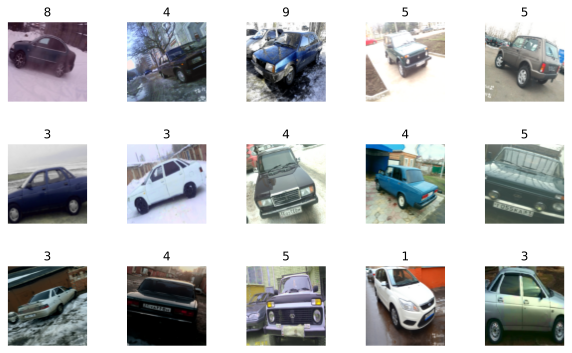

In [ ]:
# посмотрим результаты как изменились картинки после аугментации
train_generator.show_data(rows=3, cols=5)

In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
 x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = BatchNormalization()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
# x = BatchNormalization()(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

In [ ]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
463/463 [==============================] - 1328s 3s/step - loss: 0.6993 - accuracy: 0.7513 - val_loss: 0.1508 - val_accuracy: 0.9482

Epoch 00001: saving model to best_model.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/5
463/463 [==============================] - 1292s 3s/step - loss: 0.2355 - accuracy: 0.9150 - val_loss: 0.1148 - val_accuracy: 0.9572

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
463/463 [==============================] - 1290s 3s/step - loss: 0.1727 - accuracy: 0.9350 - val_loss: 0.1312 - val_accuracy: 0.9527

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
463/463 [==============================] - 1293s 3s/step - loss: 0.1475 - accuracy: 0.9435 - val_loss: 0.0923 - val_accuracy: 0.9675

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
463/463 [==============================] - 1291s 3s/step - loss: 0.1305 - accuracy: 0.9508 - val_loss: 0.0790 - val_accuracy: 0.9707

Epoch 00005: saving model to best_model.hdf5


In [ ]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


98/98 [==============================] - 59s 597ms/step - loss: 0.0790 - accuracy: 0.9707
Accuracy: 97.07%


# Вывод по размеру изображений подаваемых на вход сети:
Accuracy: 97.07%
Подаем на вход сети картинки размером 320х320 и получаем улучшение метрики!

Посмотрим на графики обучения:

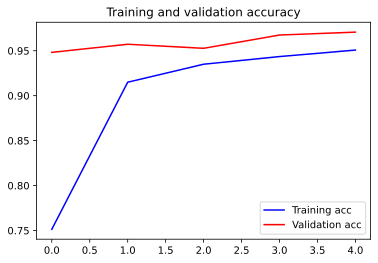

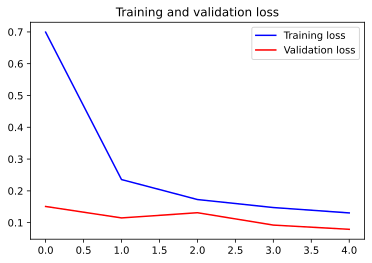

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

Предскажем на тестовых данных:

In [ ]:
test_sub_generator.samples

6675

In [ ]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


209/209 [==============================] - 126s 601ms/step


In [ ]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

Save submit


In [ ]:
from google.colab import files
files.download('submission.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Получили на тестовых данных результат 0.95777 это лучший!

Подадим еще больший размер изображений в сеть 512х512, для этого придется уменьшить BATCH_SIZE до 8, иначе не вмещается в GPU

In [ ]:
K.clear_session() # очищаем сессию keras

In [ ]:
# В setup выносим основные настройки: так удобнее их перебирать в дальнейшем.
# Изображения подаваемые в сеть уменьшил до 128 чтобы сократить время обучения
EPOCHS               = 5  # эпох на обучение
BATCH_SIZE           = 8 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.05 # сколько данных выделяем на тест = 5%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 512 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '/content/drive/MyDrive/Ford_vs_Ferrari/'
PATH = "../working/car/" # рабочая директория

RANDOM_SEED =42

In [ ]:
AUGMENTATIONS = A.Compose([
    A.RandomBrightness(limit=0.2, p=0.5),
    A.HueSaturationValue(p=0.5),
    A.GaussianBlur(p=0.05),
    A.RGBShift(p=0.5),
    A.Rotate(limit=30,
             interpolation=1,
             border_mode=4,
             value=None,
             mask_value=None,
             always_apply=False,
             p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625,
                       scale_limit=0.01,
                       interpolation=1,
                       border_mode=4,
                       rotate_limit=20,
                       p=.75),
    A.OneOf([
        A.CenterCrop(height=224, width=200),
        A.CenterCrop(height=200, width=224)],
        p=0.5),
    A.OneOf([
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)],
        p=0.5),
    A.HorizontalFlip(p=0.5),
    A.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    A.Resize(IMG_SIZE, IMG_SIZE)
])
train_datagen=ImageDataAugmentor(
        rescale=1./255,
        augment=AUGMENTATIONS,
        validation_split=VAL_SPLIT
        )
val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
)

test_datagen = ImageDataGenerator(rescale = 1/255)

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/transforms.py:1746: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


In [ ]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data




test_generator = val_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

/usr/local/lib/python3.7/dist-packages/ImageDataAugmentor/image_data_augmentor.py:332: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 14788 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.
Found 6675 validated image filenames.


In [ ]:
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

In [ ]:
 x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = BatchNormalization()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
# x = BatchNormalization()(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=LR), metrics=["accuracy"])

In [ ]:
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['val_accuracy'] , verbose = 1  , mode = 'max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

NameError: ignored

In [ ]:
model.save('../working/model_last.hdf5')
model.load_weights('best_model.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


98/98 [==============================] - 59s 597ms/step - loss: 0.0790 - accuracy: 0.9707
Accuracy: 97.07%


In [ ]:
test_sub_generator.samples

6675

In [ ]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


209/209 [==============================] - 126s 601ms/step


In [ ]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

Save submit


In [ ]:
from google.colab import files
files.download('submission.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

К сожалению закончился лимит на использование GPU от colab, но предположу что в результате подачи в сеть изображений размером 512х512 получим результат еще лучше чем в эксперименте с изображениями 320х320. Здесь нужно исходить из поставленной задачи: с изображениями 512х512 время обучения больше в разы еще из-за того, что приходится уменьшать batch_size до 8, а у нас и так на тестовых данных достаточно неплохая точность - почти 96%.

## ИТОГИ:

В ходе выполнения проекта была обучена нейронная сеть и с ее помощью изображения разбиты на 10 классов с точностью 96%

* Были протестированы различные варианты аугментации изображении

* Рассмотрено влияние на результаты обучения различных разбиений выборки на трейн и валидационную

* Проверено как сеть обучается с различным значением learning_rate

* Сравнение результатов обучения на данной задаче таких нейросетей как Xception, ResNet152V2, EfficientNetB3, InceptionResNetV2

* Попробовал добавить batch_normalisation  в "голову" модели.

* В проекте был поставлен экперимент с finetuning модели, пошаговая разморозка слоев.

* Так же была использована библиотека аугментаций  ABLUMENTATIONS

* Поставлен эксперимент с использованием TTA(Test Time Augmentation), который мог дать прирост точности, за счет усреденения ответов

При наличии большего количества времени можно было бы :
1. Досчитать варианты с подачей в сеть изображений большого размера (прим.512х512)
2. Попробовать разные optimizer  и loss  функции.
3. Попробовать эксперименты с разной архитектурой "головы"
4. При помощи парсинга получить еще некоторое количество изображений для лучшего обучения модели.